# Notebook
Notebook for prototyping and experimenting. 

### New Simulation Config


In [ ]:

# beam_settings = load_beam_config(config["beam"])

# lenses = [load_lens_config(lc) for lc in config["lenses"]]
# stages = [load_sim_stage_config(sc) for sc in config["stages"]]

# options = generate_simulation_options(config, "log")
# parameters = generate_simulation_parameters(config)


# sim_config = SimulationConfig(
#     beam=beam_settings,
#     lenses=lenses,
#     stages=stages,
#     parameters=parameters,
#     options=options
# )


# print("SIM CONFIG:")
# pprint(sim_config.beam)
# print("-"*50)
# pprint(sim_config.lenses)
# print("-"*50)
# pprint(sim_config.stages)
# print("-"*50)
# pprint(sim_config.parameters)
# print("-"*50)
# pprint(sim_config.options)



## Electric Field Refactor
Restructure the simulation to use electric field propagation rather than lenses



In [ ]:
%load_ext autoreload
%autoreload 2

from juno import utils, plotting
from juno.beam import generate_beam
from juno.Simulation import (generate_beam_simulation_stage, generate_simulation_parameters, 
    generate_sq_freq_arr, propagate_over_distance)
from juno import Simulation
from pprint import pprint
from juno.Lens import Lens
from scipy import fftpack
from juno.structures import SimulationStage, SimulationParameters, SimulationOptions, SimulationResult
from tqdm import tqdm
import numpy as np
import zarr
import matplotlib.pyplot as plt

path = "test"
config = utils.load_config("example/sim_charizard_2d.yaml")
config["log_dir"] = "log"

sim = Simulation.Simulation(config)
sim.run_simulation()

plotting.save_propagation_gif_full(sim.options.log_dir)


In [ ]:
from IPython.display import Image

plt.close()
fig = plotting.plot_sim_propagation_v2(sim.options.log_dir)
plt.show()

arr = plotting.load_full_sim_propagation_v2(sim.options.log_dir)
fig = plt.figure(figsize=(15, 15))
plt.imshow(np.flip(arr[-4,:, :]), aspect="auto", cmap="turbo")
plt.show()

Image(os.path.join(sim.options.log_dir, "propagation.gif"))



In [ ]:
from juno.beam import create_gaussian

path = "test"
config = utils.load_config("example/sim_gaussian_2d.yaml")
config["log_dir"] = path

parameters = generate_simulation_parameters(config)
beam_stage = generate_beam_simulation_stage(config, parameters)

z0 = 400.e-3
r0 = (0, 0)
w0 = 40.e-3

# parameters.sim_wavelength = 30e-3
arr = create_gaussian(r0, w0, z0, parameters=parameters, theta=0, phi=0)

print(parameters)

plt.imshow(np.abs(arr), cmap="turbo", aspect="auto")
plt.title("Gaussian")
plt.colorbar()
plt.show()

np.save("custom/gaussian.npy", arr)

fname = config["beam"]["data"]
loaded = utils.load_np_arr(fname)

plt.imshow(np.abs(loaded), cmap="turbo", aspect="auto")
plt.title("Gaussian (Loaded")
plt.colorbar()
plt.show()


In [ ]:
from PIL import Image
# star https://www.freeiconspng.com/images/white-star-icon
#fair use charizard https://en.wikipedia.org/wiki/Charizard#/media/File:Pok%C3%A9mon_Charizard_art.png
img = Image.open("custom/charizard.png")
img = img.resize((501, 501)).convert("L")
arr = np.asarray(img)
arr = arr>0 * 10000

arr = np.pad(arr, (1000, 1000), mode="constant", constant_values=0)

print(arr.shape)
plt.imshow(arr)
plt.show()

np.save("custom/charizard.npy", arr)

fname = config["beam"]["data"]
loaded = utils.load_np_arr("custom/charizard.npy")

plt.imshow(np.abs(loaded), cmap="turbo", aspect="auto")
plt.title("Charizard (Loaded")
plt.colorbar()
plt.show()

from scipy import fftpack
fft_charizard = fftpack.fft2(arr)

plt.imshow(abs(fft_charizard)**2, cmap="turbo")
plt.show()

np.save("custom/fft_charizard.npy", fft_charizard)


#### Napari Development

In [ ]:
from juno import utils, plotting
import napari
import numpy as np
path = r"C:\Users\pcle0002\Documents\repos\juno\log\duly-humble-sponge/saving-shiner"
# path = r"C:\Users\pcle0002\Documents\repos\juno\log\gently-stable-flea\intent-ibex"
sim = plotting.load_full_sim_propagation_v3(path)


viewer = napari.Viewer(ndisplay=3)
# mask = sim > 1e8
viewer.add_image(sim, name="simulation", scale=[1, 0.1, 0.1] ,rendering="mip", depiction="volume", interpolation="nearest", colormap="turbo")
# viewer.add_image(np.log(sim +1e-12), name="log_simulation", scale=[1, 0.1, 0.1] ,rendering="mip", depiction="volume", interpolation="nearest", colormap="turbo")

In [ ]:
fig = plotting.plot_sim_propagation_v2(path, log=True)
plt.show()

In [ ]:



config = utils.load_config("config.yaml")

from juno.Lens  import generate_lens
from juno.Medium import Medium

lens = generate_lens(config["lenses"][0],  Medium(2.348), 1e-6)

plotting.plot_lens_profile_2D(lens)
# plt.show()
arr3d = plotting.create_3d_lens(lens)

plotting.view_lens3d_in_napari(arr3d)

In [ ]:
%load_ext autoreload
%autoreload 2

### Napari Lens Creator
from napari.layers import Image
import napari.types 
import numpy as np
from magicgui import magicgui
import napari

from pprint import pprint
from juno import utils, plotting
from juno.Lens  import LensType, generate_lens
from juno.Medium import Medium
from pathlib import Path

In [ ]:
from magicgui.widgets import FunctionGui

MICRON_TO_METRE = 1e-6
METRE_TO_MICRON = 1e6

config = utils.load_config("config.yaml")
lens_config = config["lenses"][0]

# core
exponent = lens_config["exponent"]
diameter = lens_config["diameter"] * METRE_TO_MICRON
height = lens_config["height"] * METRE_TO_MICRON
length = lens_config["length"] * METRE_TO_MICRON if lens_config["length"] is not None else 0.0
escape_path = lens_config["escape_path"] if lens_config["escape_path"] is not None else 0.0
invert = lens_config["inverted"]
lens_type = LensType[lens_config["lens_type"]]

pprint(lens_config["lens_type"])
pprint(lens_type)

# grating
grating = True if lens_config["grating"] is not None else False
grating_width = lens_config["grating"]["width"] * METRE_TO_MICRON
grating_distance = lens_config["grating"]["distance"] * METRE_TO_MICRON
grating_depth = lens_config["grating"]["depth"] * METRE_TO_MICRON
grating_x = lens_config["grating"]["x"]
grating_y = lens_config["grating"]["y"]
grating_centred = lens_config["grating"]["centred"]


# truncation
truncation = True if lens_config["truncation"] is not None else False
truncation_height =  lens_config["truncation"]["height"] * METRE_TO_MICRON
truncation_radius = lens_config["truncation"]["radius"] * METRE_TO_MICRON
truncation_type = lens_config["truncation"]["type"] 
truncation_aperture = lens_config["truncation"]["aperture"]

# aperture
aperture =  True if lens_config["aperture"] is not None else False
aperture_inner = lens_config["aperture"]["inner"] * METRE_TO_MICRON
aperture_outer = lens_config["aperture"]["outer"] * METRE_TO_MICRON
aperture_type = lens_config["aperture"]["type"] 
aperture_invert = lens_config["aperture"]["invert"] 


@magicgui(auto_call=True, call_button="Create Lens", 
  truncation_type={"choices": ["value", "radial"]}, 
  aperture_type={"choices": ["radial", "square"]},
  save_path={"label": "Select a save path:", "filter": "*.yml, *.yaml"},
  load_path={"label": "Select a load path:"})
def create_lens(
    load_path: Path = "config.yaml",
    exponent:float = exponent, diameter: float = diameter,
    height: float =height,
    length: float = length,
    escape_path: float = escape_path, 
    lens_type: LensType = lens_type,
    invert:bool = invert , 
    grating: bool = grating, 
    grating_width = grating_width, 
    grating_distance = grating_distance, 
    grating_depth = grating_depth, 
    grating_x = grating_x, grating_y = grating_y, grating_centred = grating_centred,
    truncation: bool = truncation,
    truncation_height = truncation_height, truncation_radius = truncation_radius, 
    truncation_type = truncation_type, truncation_aperture = truncation_aperture,
    aperture: bool = aperture,
    aperture_inner =  aperture_inner, aperture_outer = aperture_outer, 
    aperture_type = aperture_type, aperture_invert = aperture_invert,
    pixel_size = 1.0,
    
    save_path: Path = "",

    ) -> napari.types.LayerDataTuple:
  
  if load_path == ".":
    load_path = "config.yaml"

  config = utils.load_config(load_path)
  lens_config = config["lenses"][0]


  # set widgets?
  # create_lens.height.bind() #.height = lens_config["height"] * METRE_TO_MICRON
  # FunctionGui.diameter = lens_config["diameter"] * METRE_TO_MICRON
  # create_lens. #exponent.bind(lens_config["exponent"])

  













  # core
  lens_config["height"] = height * MICRON_TO_METRE
  lens_config["diameter"] = diameter * MICRON_TO_METRE
  lens_config["exponent"] = exponent
  lens_config["inverted"] = invert
  lens_config["escape_path"] = escape_path
  lens_config["length"] = length * MICRON_TO_METRE
  lens_config["lens_type"] = lens_type.name

  # print(lens_config["lens_type"])
  
  # grating
  if grating:
    lens_config["grating"] = {}
    lens_config["grating"]["width"] = grating_width * MICRON_TO_METRE
    lens_config["grating"]["distance"] = grating_distance * MICRON_TO_METRE
    lens_config["grating"]["depth"] = grating_depth * MICRON_TO_METRE
    lens_config["grating"]["x"] = grating_x 
    lens_config["grating"]["y"] = grating_y 
    lens_config["grating"]["centred"] = grating_centred 
  else:
    lens_config["grating"] = None
  
  # truncation
  if truncation:
    lens_config["truncation"] = {}
    lens_config["truncation"]["height"] = truncation_height * MICRON_TO_METRE
    lens_config["truncation"]["radius"] = truncation_radius * MICRON_TO_METRE
    lens_config["truncation"]["type"] = truncation_type 
    lens_config["truncation"]["aperture"] = truncation_aperture
  else:
    lens_config["truncation"] = None
  
  # aperture
  if aperture:
      lens_config["aperture"] = {}
      lens_config["aperture"]["inner"] = aperture_inner * MICRON_TO_METRE
      lens_config["aperture"]["outer"] = aperture_outer * MICRON_TO_METRE
      lens_config["aperture"]["type"] = aperture_type 
      lens_config["aperture"]["invert"] = aperture_invert
  else:
    lens_config["aperture"] = None

  lens = generate_lens(lens_config, Medium(2.348), pixel_size*MICRON_TO_METRE)

  arr3d = plotting.create_3d_lens(lens)

  return [(arr3d, {"name": "Lens", "colormap": "gray", "rendering": "iso", "depiction": "volume"}),
          (lens.aperture, {"name": "Lens Aperture", "opacity": 0.4, "colormap": "yellow", "rendering": "translucent"}, "image"),
          (lens.grating_mask, {"name": "Lens Grating Mask", "opacity": 0.4, "colormap": "green", "rendering": "translucent"}, "image"),
          (lens.truncation_mask, {"name": "Lens Truncation Mask", "opacity": 0.4, "colormap": "cyan", "rendering": "translucent"}, "image")]


# TODO: 
# load config
# load custom
# save lens
# name
# lens_type

viewer = napari.Viewer(ndisplay=3)
viewer.axes.visible = True
viewer.axes.colored = False
viewer.axes.dashed = True
viewer.axes.labels = True
viewer.scale_bar.visible = True
viewer.window.add_dock_widget(create_lens)
create_lens()


In [ ]:

@magicgui(auto_call=False, call_button="View Results", 
  load_path={"label": "Select a simulation path:", "mode": "d" },
  threshold={"max": 1e20})
def view_results(load_path: Path = r"C:\Users\pcle0002\Documents\repos\juno\juno\example\tutorial_simulation_results/active-shark", 
  log_plot: bool = False, threshold: float = 0.1, scale_dim:float = 0.01) -> napari.types.LayerDataTuple:

  sim_name = os.path.basename(load_path)

  sim = plotting.load_full_sim_propagation_v3(load_path)

  if log_plot:
    sim = np.log(sim + 1e-12)

  sim = sim>threshold
 
  return [
    (sim, {"name": sim_name, "colormap": "turbo", "rendering": "average", "scale": [1, scale_dim, scale_dim]}),
  ]

viewer = napari.Viewer(ndisplay=3)
viewer.axes.visible = True
viewer.axes.dashed = True
viewer.axes.labels = True
viewer.axes.colored = False
viewer.scale_bar.visible = True
viewer.window.add_dock_widget(view_results)

path = r"C:\Users\pcle0002\Documents\repos\juno\juno\example\tutorial_simulation_results/active-shark"
view_results(path)



# https://github.com/napari/magicgui/issues/20

In [ ]:
"""
Napari provides a few conveniences with magicgui, and one of the
most commonly used is the layer combo box that gets created when
a parameter is annotated as napari.layers.Layer.
The layer box will stay in sync with the viewer model, adding and
removing layers as needed.
This example shows how to use just that widget in the context
of a larger custom QWidget.
"""
import napari
from qtpy.QtWidgets import QVBoxLayout, QWidget

from magicgui.widgets import create_widget


class CustomWidget(QWidget):
    def __init__(self) -> None:
        super().__init__()
        self.setLayout(QVBoxLayout())
        # change annotation to napari.layers.Image (e.g) to restrict to just Images
        self._layer_combo = create_widget(annotation=napari.layers.Layer)
        # magicgui widgets hold the Qt widget at `widget.native`
        self.layout().addWidget(self._layer_combo.native)


viewer = napari.Viewer()
viewer.add_points()
viewer.add_points()

my_widget = CustomWidget()
viewer.window.add_dock_widget(my_widget)

my_widget1 = CustomWidget()
viewer.window.add_dock_widget(my_widget1, name="my_widget")
# when my_widget is a magicgui.Widget, it will detect that it has been added
# to a viewer, and automatically update the choices.  Otherwise, you need to
# trigger this yourself:
my_widget._layer_combo.reset_choices()
viewer.layers.events.inserted.connect(my_widget._layer_combo.reset_choices)
viewer.layers.events.removed.connect(my_widget._layer_combo.reset_choices)

my_widget1._layer_combo.reset_choices()
viewer.layers.events.inserted.connect(my_widget1._layer_combo.reset_choices)
viewer.layers.events.removed.connect(my_widget1._layer_combo.reset_choices)

napari.run()

In [ ]:
%load_ext autoreload 
%autoreload 2
import sys

import napari

import juno.ui.qtdesigner_files.LensSimulation as LensSimulation
from juno.ui.BeamCreator import GUIBeamCreator
from juno.ui.LensCreator import GUILensCreator
from juno.ui.SimulationRun import GUISimulationRun
from juno.ui.SimulationSetup import GUISimulationSetup
from juno.ui.VisualiseResults import GUIVisualiseResults
from PyQt5 import QtWidgets
lens_creator = GUILensCreator()

viewer = napari.Viewer(ndisplay=3)
viewer.window.add_dock_widget(lens_creator)

napari.run()

In [ ]:
from magicgui import magicgui


@magicgui(auto_call=True, width={"max": 800, "min": 100}, x={"widget_type": "Slider"})
def function(width=400, x: int = 50):
    # the widget can reference itself, and use the widget API
    function.x.width = width


function.show(run=True)

In [ ]:
from magicgui.widgets import request_values

vals = request_values(
    age=int,
    name=dict(annotation=str, label="Enter your name:"),
    title="Hi, who are you?",
)
print(repr(vals))

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import dask.array as da



profile = da.zeros(shape=(501, 501))
output = da.zeros(shape=(251, 251))

print(profile.shape)
print(output.shape)

from pprint import pprint
from juno import utils

output = utils.pad_to_equal_size(output, profile)

print(output.shape)

stack = da.stack([profile, output])
print(stack.shape)

In [ ]:
stack.shape

In [ ]:
path = r"C:\Users\pcle0002\Documents\repos\juno\juno\example\sim_focus_2d.yaml"
config = utils.load_config(path)


from juno import plotting, utils

arr = plotting.plot_simulation_setup_v2(config)


### Circular and Blur Gratings

In [95]:
%load_ext autoreload
%autoreload 2

from juno.Lens import Lens, generate_lens
from juno import utils
from pprint import pprint
from juno.Medium import Medium

import matplotlib.pyplot as plt


path = r"/home/patrick/github/juno/juno/example/sim_focus_2d.yaml"
config = utils.load_config(path)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
lens_config = config["lenses"][0]

lens_config["grating"] = {
    "width": 10e-6,
    "distance": 10.1e-6,
    "depth": 2e-6,
    "x": True,
    "y": True,
    "centred": True,
    "mode": "radial",
    "blur": True,
    "inner_radius": 10e-6,
}

In [107]:
pixelsize = 1e-6
lens = generate_lens(lens_config, Medium(2.348), pixel_size=pixelsize)

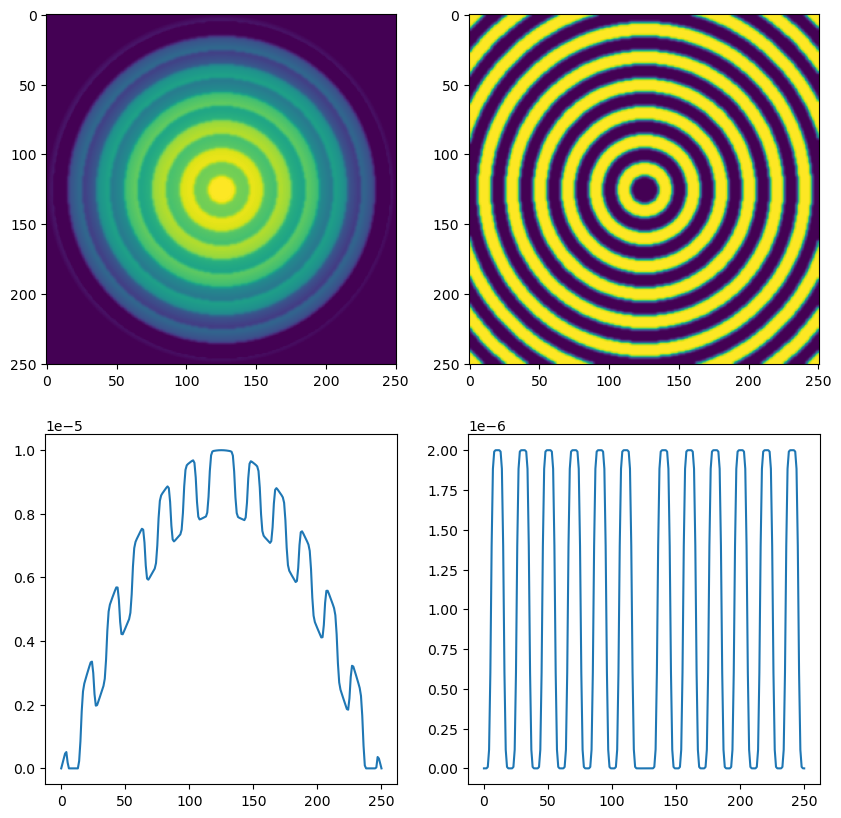

In [108]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(lens.profile)
ax[0][1].imshow(lens.grating_mask)
ax[1][0].plot(lens.profile[lens.profile.shape[0]//2, :])
ax[1][1].plot(lens.grating_mask[lens.profile.shape[0]//2, :])
plt.show()